# Importing dataset from kaggle


In [1]:
!pip install kagglehub

In [2]:
from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json file


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sampatel17","key":"f6beb7a148381a21ea0e38ea55bcc393"}'}

In [3]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')


In [4]:
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)


100%|██████████| 2.29G/2.29G [00:10<00:00, 241MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


#Importing essential libraries

check for unwanted libraries

In [5]:
# Core Libraries
import numpy as np
import pandas as pd
import os
import glob

# PyTorch Core Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# PyTorch Vision Libraries
from torchvision import datasets, transforms, models

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns  # Optional, for enhanced visualization

# Image Processing
from PIL import Image
import cv2  # Optional, for advanced image processing tasks

# Utility Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Optional Libraries
#import albumentations as A  # For advanced image augmentation (if needed)


# 1. Load Datasets - Train, Test, Valid

BASE_PATH = /kaggle/input/chest-xray-pneumonia/chest_xray

This section prepares and summarizes a chest X-ray dataset for pneumonia detection. It defines a function, **load_image_paths**, to load image file paths for "NORMAL" and "PNEUMONIA" cases from specified dataset folders ("train", "val", and "test"). The base directory path is set, and the function is used to retrieve and count the images in each category and dataset type. A summary of the dataset's size and distribution is stored in a dictionary, dataset_stats, and printed, showing the total images and their breakdown by category for training, validation, and testing sets. This provides an organized overview for further analysis.



In [6]:
def load_image_paths(base_path, dataset_type):
    # Corrected the path for loading images under 'chest_xray' folder.
    normal_images = glob.glob(os.path.join(base_path, dataset_type, "NORMAL", "*.jpeg"))
    pneumonia_images = glob.glob(os.path.join(base_path, dataset_type, "PNEUMONIA", "*.jpeg"))
    return normal_images, pneumonia_images

# Base path for the dataset (updated from printed path)
BASE_PATH = '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray'

# Load image paths for train, test, and validation sets
train_normal, train_pneumonia = load_image_paths(BASE_PATH, "train")
test_normal, test_pneumonia = load_image_paths(BASE_PATH, "val")  # folder has confusing name
val_normal, val_pneumonia = load_image_paths(BASE_PATH, "test")

# Count the number of images
dataset_stats = {
    "Train": {"NORMAL": len(train_normal), "PNEUMONIA": len(train_pneumonia)},
    "Validation": {"NORMAL": len(val_normal), "PNEUMONIA": len(val_pneumonia)},
    "Test": {"NORMAL": len(test_normal), "PNEUMONIA": len(test_pneumonia)},
}

In [7]:
# Print dataset statistics
print("Dataset Summary:\n")
for dataset_type, stats in dataset_stats.items():
    total_images = stats["NORMAL"] + stats["PNEUMONIA"]
    print(f"{dataset_type} Set: {total_images} images")
    print(f"  NORMAL: {stats['NORMAL']} images")
    print(f"  PNEUMONIA: {stats['PNEUMONIA']} images\n")


Dataset Summary:

Train Set: 5216 images
  NORMAL: 1341 images
  PNEUMONIA: 3875 images

Validation Set: 624 images
  NORMAL: 234 images
  PNEUMONIA: 390 images

Test Set: 16 images
  NORMAL: 8 images
  PNEUMONIA: 8 images



#2. Data Exploration
This section explores the dataset by visualizing sample images and analyzing class distributions. **display_sample_images()** is used to display 5 "NORMAL" and 5 "PNEUMONIA" images from the training set, providing a quick visual inspection of the data. Additionally, class distributions for "NORMAL" and "PNEUMONIA" across training, validation, and test sets are calculated and displayed using bar charts. This helps identify potential class imbalances and ensures a better understanding of the dataset before moving to model development.

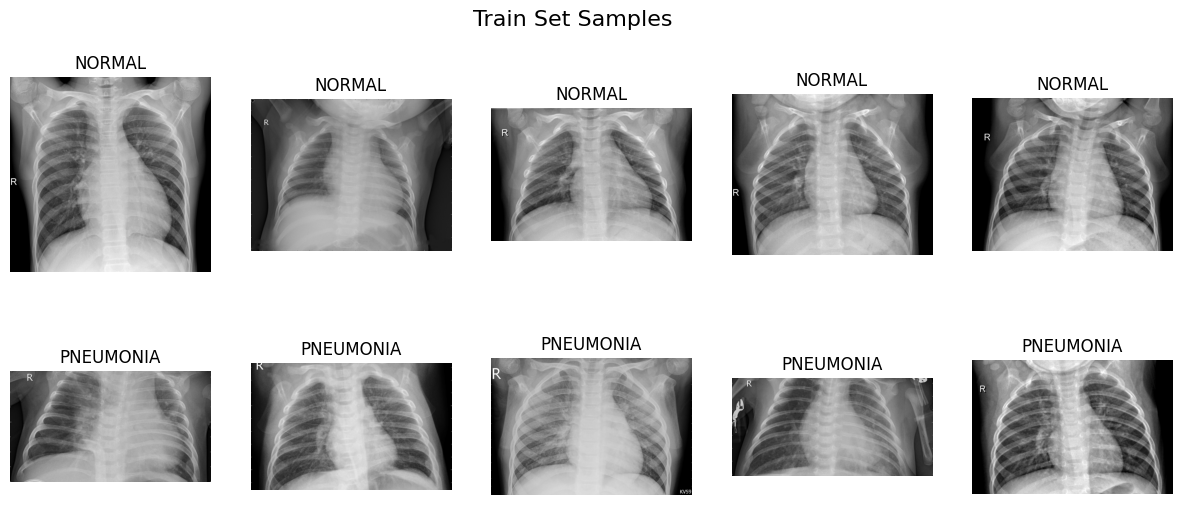

In [8]:
# Function to display a few sample images
def display_sample_images(normal_images, pneumonia_images, title):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(title, fontsize=16)

    for i in range(5):  # Display 5 NORMAL images
        img = cv2.imread(normal_images[i])
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[0, i].imshow(img)
        axes[0, i].set_title("NORMAL")
        axes[0, i].axis("off")

    for i in range(5):  # Display 5 PNEUMONIA images
        img = cv2.imread(pneumonia_images[i])
       # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[1, i].imshow(img)
        axes[1, i].set_title("PNEUMONIA")
        axes[1, i].axis("off")

    plt.show()

# Display sample images from the train set
display_sample_images(train_normal, train_pneumonia, "Train Set Samples")


Train Class Distribution: Counter({'PNEUMONIA': 3875, 'NORMAL': 1341})
Validation Class Distribution: Counter({'PNEUMONIA': 390, 'NORMAL': 234})
Test Class Distribution: Counter({'NORMAL': 8, 'PNEUMONIA': 8})


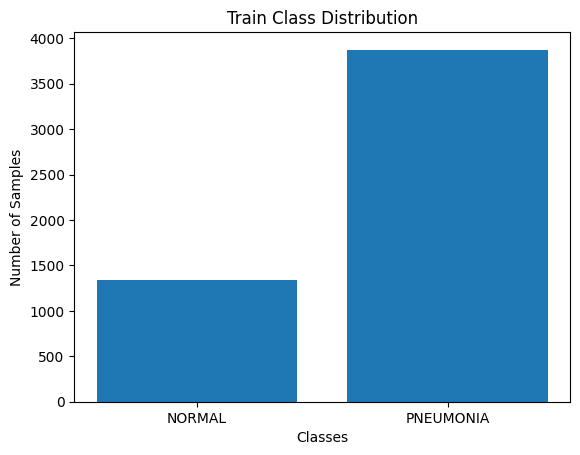

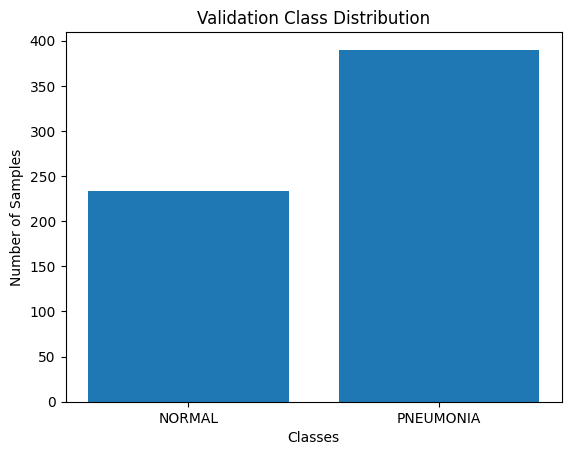

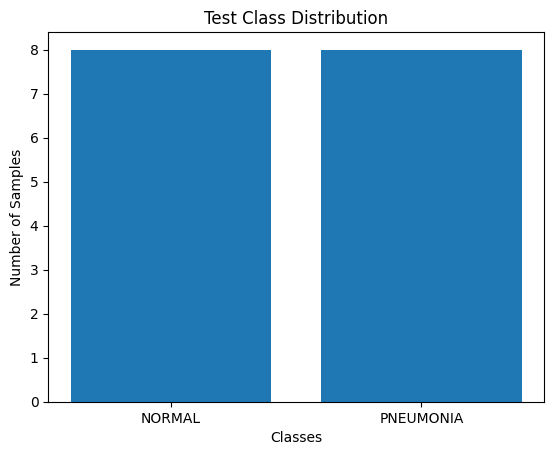

In [9]:

from collections import Counter

# Create labels for the dataset
train_labels = ['NORMAL'] * len(train_normal) + ['PNEUMONIA'] * len(train_pneumonia)
test_labels = ['NORMAL'] * len(test_normal) + ['PNEUMONIA'] * len(test_pneumonia)
val_labels = ['NORMAL'] * len(val_normal) + ['PNEUMONIA'] * len(val_pneumonia)

# Count class distributions for each set
train_counts = Counter(train_labels)
test_counts = Counter(test_labels)
val_counts = Counter(val_labels)

# Print class distributions for each set
print("Train Class Distribution:", train_counts)
print("Validation Class Distribution:", val_counts)
print("Test Class Distribution:", test_counts)

# Plot class distributions for each set
datasets = {
    "Train": train_counts,
    "Validation": val_counts,
    "Test": test_counts
}

for dataset_name, class_counts in datasets.items():
    plt.bar(class_counts.keys(), class_counts.values())
    plt.title(f"{dataset_name} Class Distribution")
    plt.xlabel("Classes")
    plt.ylabel("Number of Samples")
    plt.show()
    print('\n\n')


#3. Data Pre-Processing
* Resize
* Pixel normalize

This section preprocesses the dataset by loading, resizing, and normalizing images for training, testing, and validation. A function, load_images_and_labels, reads image paths, resizes them to 256x256 pixels, and normalizes pixel values to a range of [0, 1]. Labels (0 for "NORMAL" and 1 for "PNEUMONIA") are assigned to create structured datasets. The processed data (X_train, X_test, X_val) and labels (y_train, y_test, y_val) ensure consistent input for training machine learning models. Five of the processed and labelled images are displayed for train, validation and test class.

* Gray scale conversion:
Converts RGB images (3 channels) into grayscale images (1 channel) by averaging or using weighted combinations of the R, G, and B values.
Reduces the input size and computational complexity, as X-ray images do not require color information.
Retains essential structural and intensity details necessary for medical analysis.

* Erosion:
Applies morphological erosion, where pixels on object boundaries are eroded (reduced) based on a defined kernel.
Sharpens important regions such as edges, improving the visibility of critical features (e.g., lung boundaries in X-rays).

* Gaussian Blur:
Applies a Gaussian filter to smooth the image by averaging pixel values in the vicinity, weighted by a Gaussian distribution.
Reduces high-frequency noise while preserving the structure and intensity gradients. Enhances the clarity of large-scale patterns like lung opacities, which are crucial for identifying conditions like pneumonia.

Applying Gray scale to the image gave us a test precision of 50%.
Applying Erosion to image gave us a test precision of 50%. 

In [10]:
# Function to load images and labels from paths
def load_images_and_labels(normal_paths, pneumonia_paths, label_normal, label_pneumonia):
    images = []
    labels = []

    # Load NORMAL images
    for path in normal_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, (256, 256))  # Resize to a fixed size
        img = cv2.GaussianBlur(img, (5, 5), 0)

        """
        Using different methods to process images

        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        kernel = np.ones((5, 5), np.uint8)
        img = cv2.erode(img, kernel, iterations=1) #IMAGE EROSION
        """

        img = img / 255.0  # Normalize pixel values
        images.append(img)
        labels.append(label_normal)

    # Load PNEUMONIA images
    for path in pneumonia_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, (256, 256))  # Resize to a fixed size
        img = cv2.GaussianBlur(img, (5, 5), 0)

        """
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        kernel = np.ones((5, 5), np.uint8)
        img = cv2.erode(img, kernel, iterations=1) #IMAGE EROSION
        """

        img = img / 255.0  # Normalize pixel values
        images.append(img)
        labels.append(label_pneumonia)

    return np.array(images), np.array(labels)


# Load training images and labels
X_train, y_train = load_images_and_labels(train_normal, train_pneumonia, label_normal=0, label_pneumonia=1)
#X_train = np.expand_dims(X_train, axis=-1)  # Add a channel dimension, used when image was processed using grayscale

# Load test images and labels
X_test, y_test = load_images_and_labels(test_normal, test_pneumonia, label_normal=0, label_pneumonia=1)
#X_test = np.expand_dims(X_test, axis=-1)  # Add a channel dimension

# Load validation images and labels
X_val, y_val = load_images_and_labels(val_normal, val_pneumonia, label_normal=0, label_pneumonia=1)
#X_val = np.expand_dims(X_val, axis=-1)  # Add a channel dimension



In [11]:
def display_processed_images(X_class, y_class, title):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(title, fontsize=16)

    #Getting indices for first 5 images

    label_0_indices = np.where(y_class == 0)[0][:5]
    label_1_indices = np.where(y_class == 1)[0][:5]

    # Extract the corresponding images
    label_0_images = X_class[label_0_indices]
    label_1_images = X_class[label_1_indices]

    for i in range(5):
      # Plot images with label 0
      axes[0, i].imshow(label_0_images[i])
      axes[0, i].axis('off')
      axes[0, i].set_title("Label 0")

    # Plot images with label 1
      axes[1, i].imshow(label_1_images[i])
      axes[1, i].axis('off')
      axes[1, i].set_title("Label 1")

    plt.show()


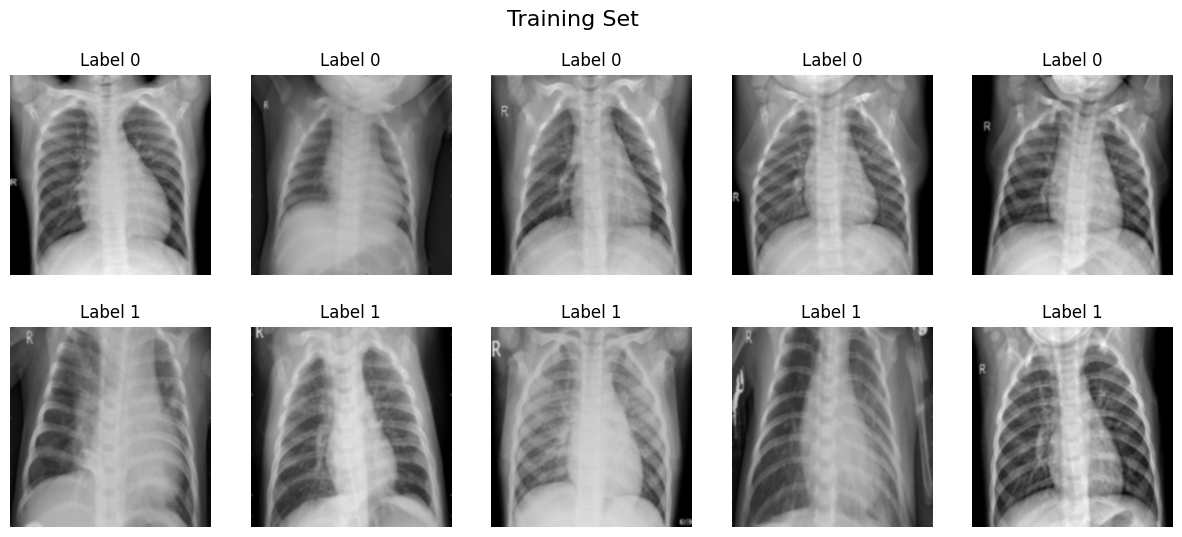

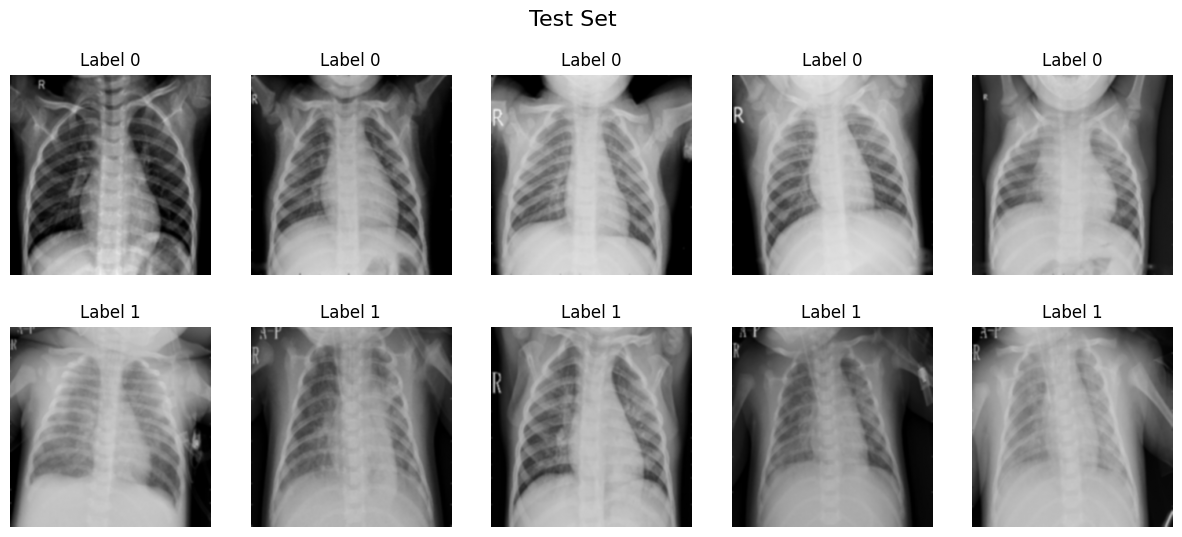

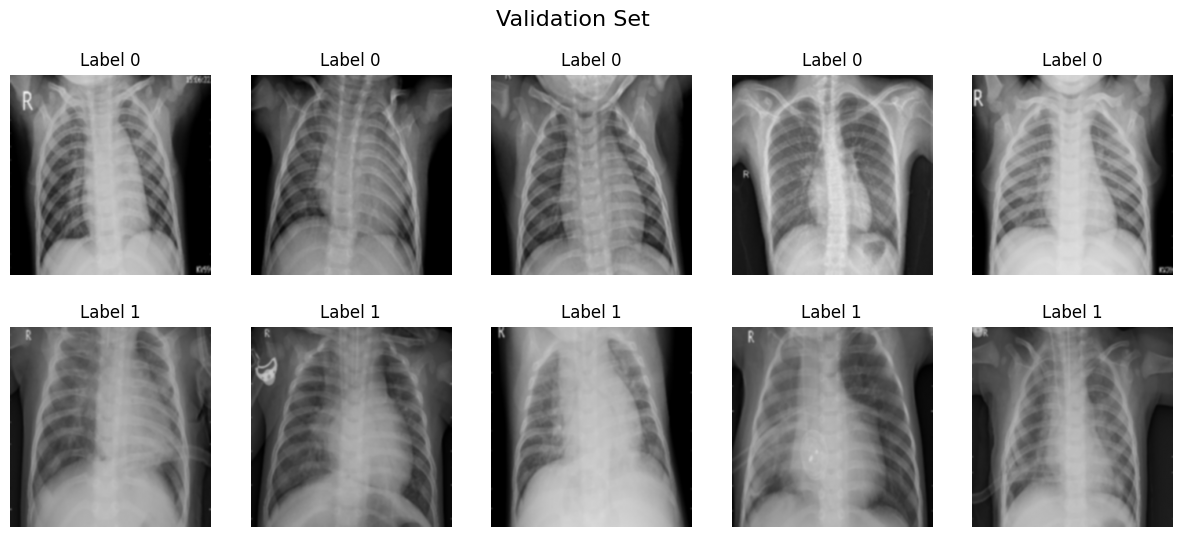

In [12]:
display_processed_images(X_train, y_train, 'Training Set')
display_processed_images(X_test, y_test, 'Test Set')
display_processed_images(X_val, y_val, 'Validation Set')

#4. Data augmentation

This section applies data augmentation to enhance the dataset by creating variations of the training images in real-time, helping the model generalize better. Using Keras's ImageDataGenerator, transformations such as random rotations, shifts, shear, zoom, and horizontal flips are applied to the training data. These augmentations simulate variations that the model might encounter in real-world scenarios. The generator is then fitted to the preprocessed training images (X_train) to prepare it for use in model training.








In [13]:
# Using Keras ImageDataGenerator to apply transformations to the images in real-time
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,  # Random rotations between -20 to 20 degrees
    width_shift_range=0.2,  # Random horizontal shifts
    height_shift_range=0.2,  # Random vertical shifts
    shear_range=0.2,  # Random shear transformations
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest',  # Fill any empty pixels resulting from transformations

)

# Fit the generator on the training data
datagen.fit(X_train)


#5. Convolution neural network

Convolutional layers process each local image region independently, using parameters shared across the whole image. They use fewer parameters than fully connected layers, exploit the spatial relationships between nearby pixels, and don’t have to re-learn the interpretation of the pixels at every position. A network predominantly consisting of convolutional layers is known as a convolutional neural network or CNN.

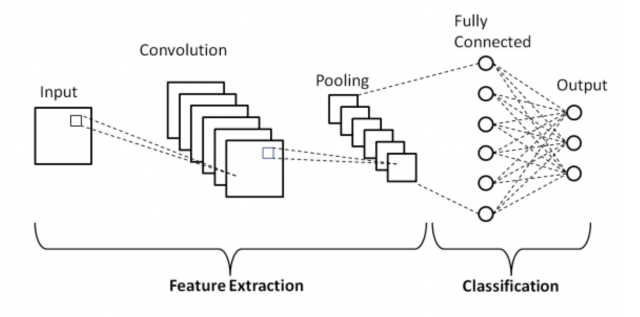



A convolutional layer extracts features from input data by using a **sliding kernel**, a small matrix that moves across the input data in a step-by-step manner. The kernel performs a **weighted sum of nearby inputs** within its receptive field, generating a **feature map** that highlights specific spatial patterns such as edges, textures, or shapes in the image. During this process, the kernel's weights are **learnable parameters**, meaning they are updated through training to improve the model's ability to detect useful features. The sliding process is controlled by parameters like **stride** (how far the kernel moves) and **dilation** (spacing between kernel elements), which influence the receptive field and the output size. This mechanism enables convolutional layers to detect hierarchical patterns in the input data, making them fundamental for tasks like image recognition.


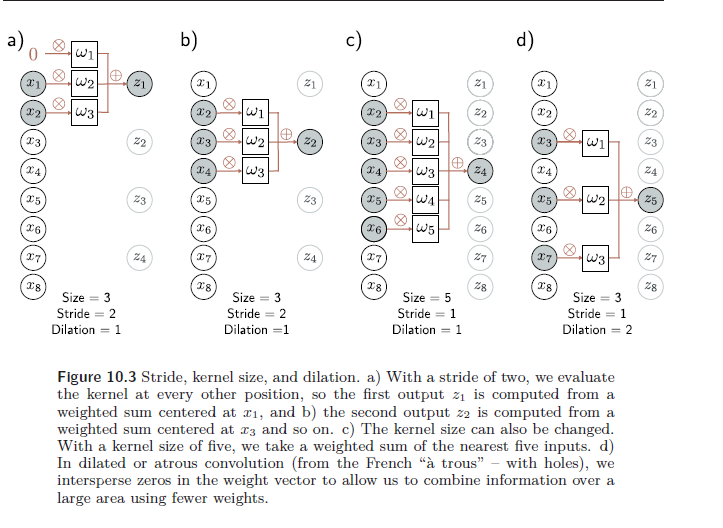



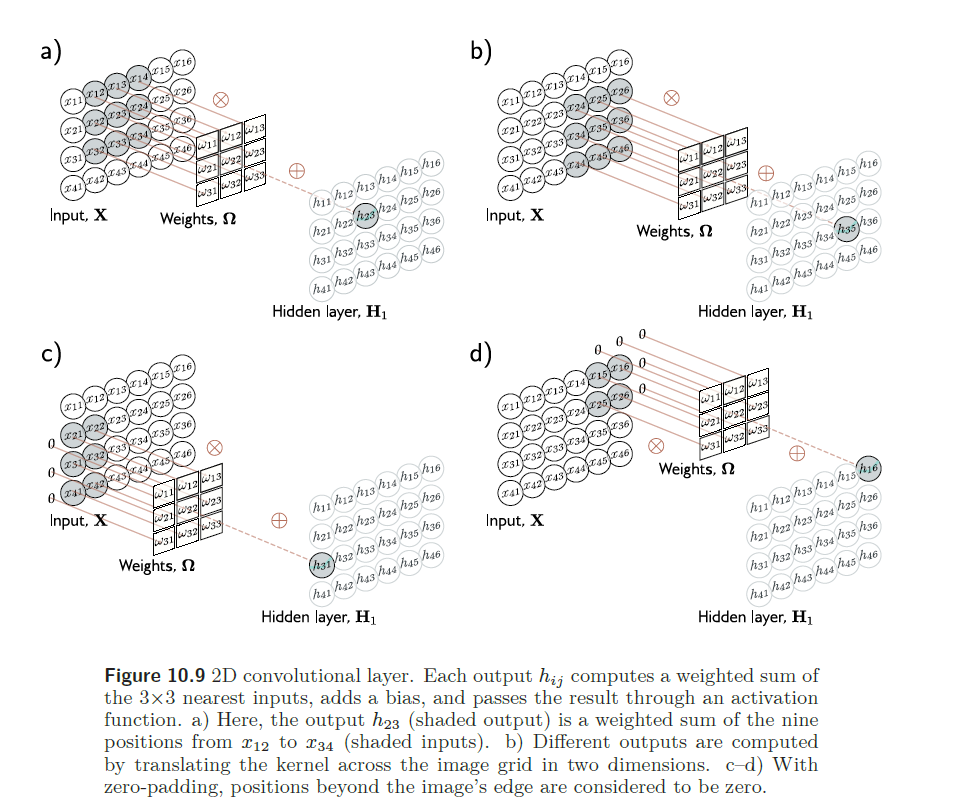

MaxPooling Layers
MaxPooling reduces the spatial dimensions of feature maps while retaining the most significant information. This operation introduces translation invariance and minimizes computation in deeper layers by selecting the maximum value from a patch of inputs.
The technique helps in reducing overfitting and computational load.
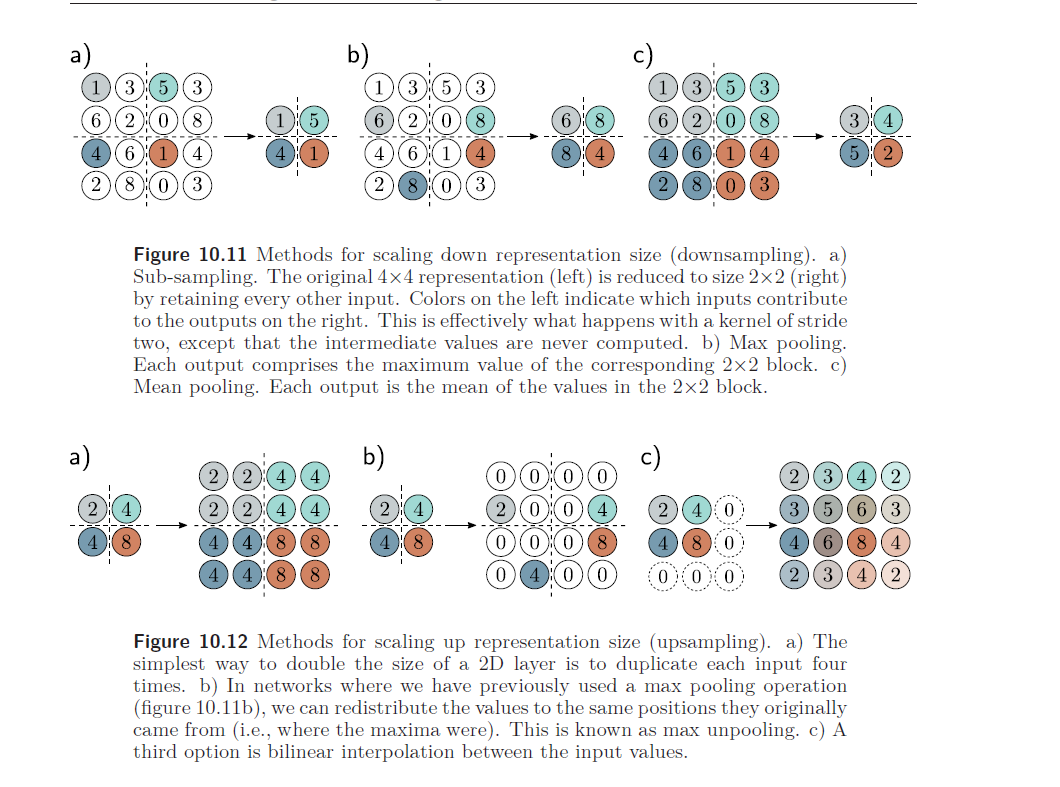

#Dropout Layers
Dropout randomly deactivates a fraction of neurons during training to prevent overfitting. This randomness ensures the model does not over-rely on specific neurons, leading to better generalization.
Dropout during training resembles training multiple smaller networks and combining them during inference.

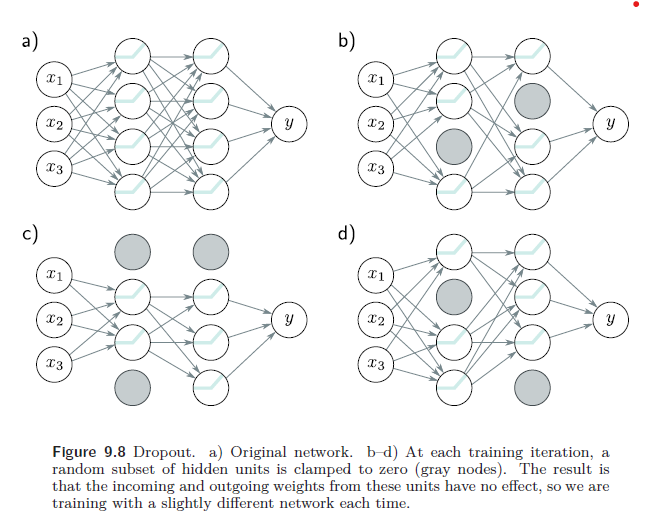

# Fully Connected Layers
Fully connected layers (Dense layers) integrate all extracted features to predict outcomes. The final Dense layer outputs a probability (via sigmoid) in binary classification tasks. This structure allows the network to learn complex relationships between input features​.

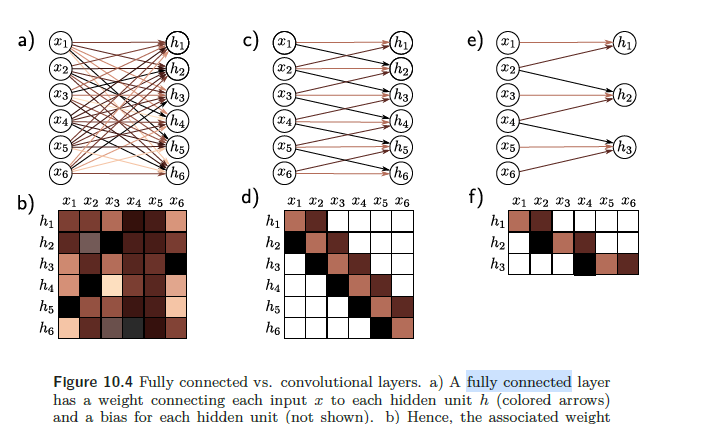

# Adam Optimizer
Adam is an optimization algorithm that adapts the learning rate based on the first and second moments of the gradients, ensuring efficient and stable convergence. It is widely used in deep learning due to its ability to handle sparse gradients and noisy data​

In [14]:
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def cnn_model_1(input_shape):
    model = models.Sequential()

    # First convolutional block with stride and padding
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    #model.add(layers.Dropout(0.25))

    # Second convolutional block with stride and padding
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Third convolutional block with stride and padding
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))
    # Flatten the features to feed into the fully connected layers
    model.add(layers.Flatten())

    # Fully connected layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout for regularization

    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer with sigmoid for binary classification

    """
    Implementing SGD with Nesterov Momentum

    sgd_optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd_optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    """
    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])



    return model


#Channel

A channel refers to the depth dimension of an input image or feature map. Channels represent the different types of information available for each spatial position.

For example:

A grayscale image has 1 channel (intensity values for each pixel).
A color image typically has 3 channels (Red, Green, Blue).



In [15]:
"""
When converting to grayscale the channel is 1.
When converting to RGB the channel is 3.

model_1 = cnn_model_1(input_shape=(256, 256, 1))
"""
model_1 = cnn_model_1(input_shape=(256, 256, 3)) ##
model_1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      16,777,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,870,721 (64.36 MB)

 Trainable params: 16,870,721 (64.36 MB)

 Non-trainable params: 0 (0.00 B)

#6. Training Model 1

**ReduceLROnPlateau Callback**
This callback dynamically reduces the learning rate if the validation accuracy plateaus, allowing the model to focus on finer details. Such adjustments enhance the network's ability to converge to an optimal solution.

**Early Stopping Callback**
Early stopping monitors the validation loss and halts training if no significant improvement is observed after a set number of epochs. This prevents overfitting and saves computational resources.

**Class Weights**
Class weights are used to counter class imbalances in datasets. In this case, class_weights ensures the network pays equal attention to both NORMAL and PNEUMONIA classes, even if their data distributions are unequal.

In [16]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

class_weights = {0: 1.945, 1: 0.673}

# Define callbacks
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=2,
    verbose=1,
    factor=0.3,
    min_lr=1e-6
)

early_stopping = EarlyStopping(
    monitor='val_loss',      # Monitor validation loss
    patience=4,              # Stop training if no improvement in 5 epochs
    verbose=1,               # Print messages when stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)


# Fit the model
history = model_1.fit(
    datagen.flow(X_train, y_train, batch_size = 8),  # Use data augmentation for training
    epochs=12,  # Increase epochs as EarlyStopping will handle stopping
    validation_data=(X_val, y_val),  # Use raw validation data (no augmentation)
    callbacks=[learning_rate_reduction,early_stopping],  # Include all callbacks
    verbose=1,
    class_weight = class_weights # Pass class weights using class_weight
)



Epoch 1/12


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


652/652 ━━━━━━━━━━━━━━━━━━━━ 81s 110ms/step - accuracy: 0.5699 - loss: 0.8910 - val_accuracy: 0.6282 - val_loss: 0.6239 - learning_rate: 0.0010
Epoch 2/12
652/652 ━━━━━━━━━━━━━━━━━━━━ 70s 106ms/step - accuracy: 0.7160 - loss: 0.5358 - val_accuracy: 0.6458 - val_loss: 0.6134 - learning_rate: 0.0010
Epoch 3/12
652/652 ━━━━━━━━━━━━━━━━━━━━ 69s 106ms/step - accuracy: 0.8084 - loss: 0.4773 - val_accuracy: 0.6554 - val_loss: 0.6270 - learning_rate: 0.0010
Epoch 4/12
652/652 ━━━━━━━━━━━━━━━━━━━━ 70s 106ms/step - accuracy: 0.8271 - loss: 0.4288 - val_accuracy: 0.6490 - val_loss: 0.5465 - learning_rate: 0.0010
Epoch 5/12
652/652 ━━━━━━━━━━━━━━━━━━━━ 70s 107ms/step - accuracy: 0.8207 - loss: 0.4271 - val_accuracy: 0.7260 - val_loss: 0.4972 - learning_rate: 0.0010
Epoch 6/12
652/652 ━━━━━━━━━━━━━━━━━━━━ 69s 105ms/step - accuracy: 0.8449 - loss: 0.3551 - val_accuracy: 0.8173 - val_loss: 0.3980 - learning_rate: 0.0010
Epoch 7/12
652/652 ━━━━━━━━━━━━━━━━━━━━ 69s 105ms/step - accuracy: 0.8583 - loss:

#Evaluating Model 1


In [17]:
print("Loss of the model is - " , model_1.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model_1.evaluate(X_test,y_test)[1]*100 , "%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8125 - loss: 0.3317
Loss of the model is -  0.3316669464111328
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8125 - loss: 0.3317
Accuracy of the model is -  81.25 %


# Accuracy v/s loss curve

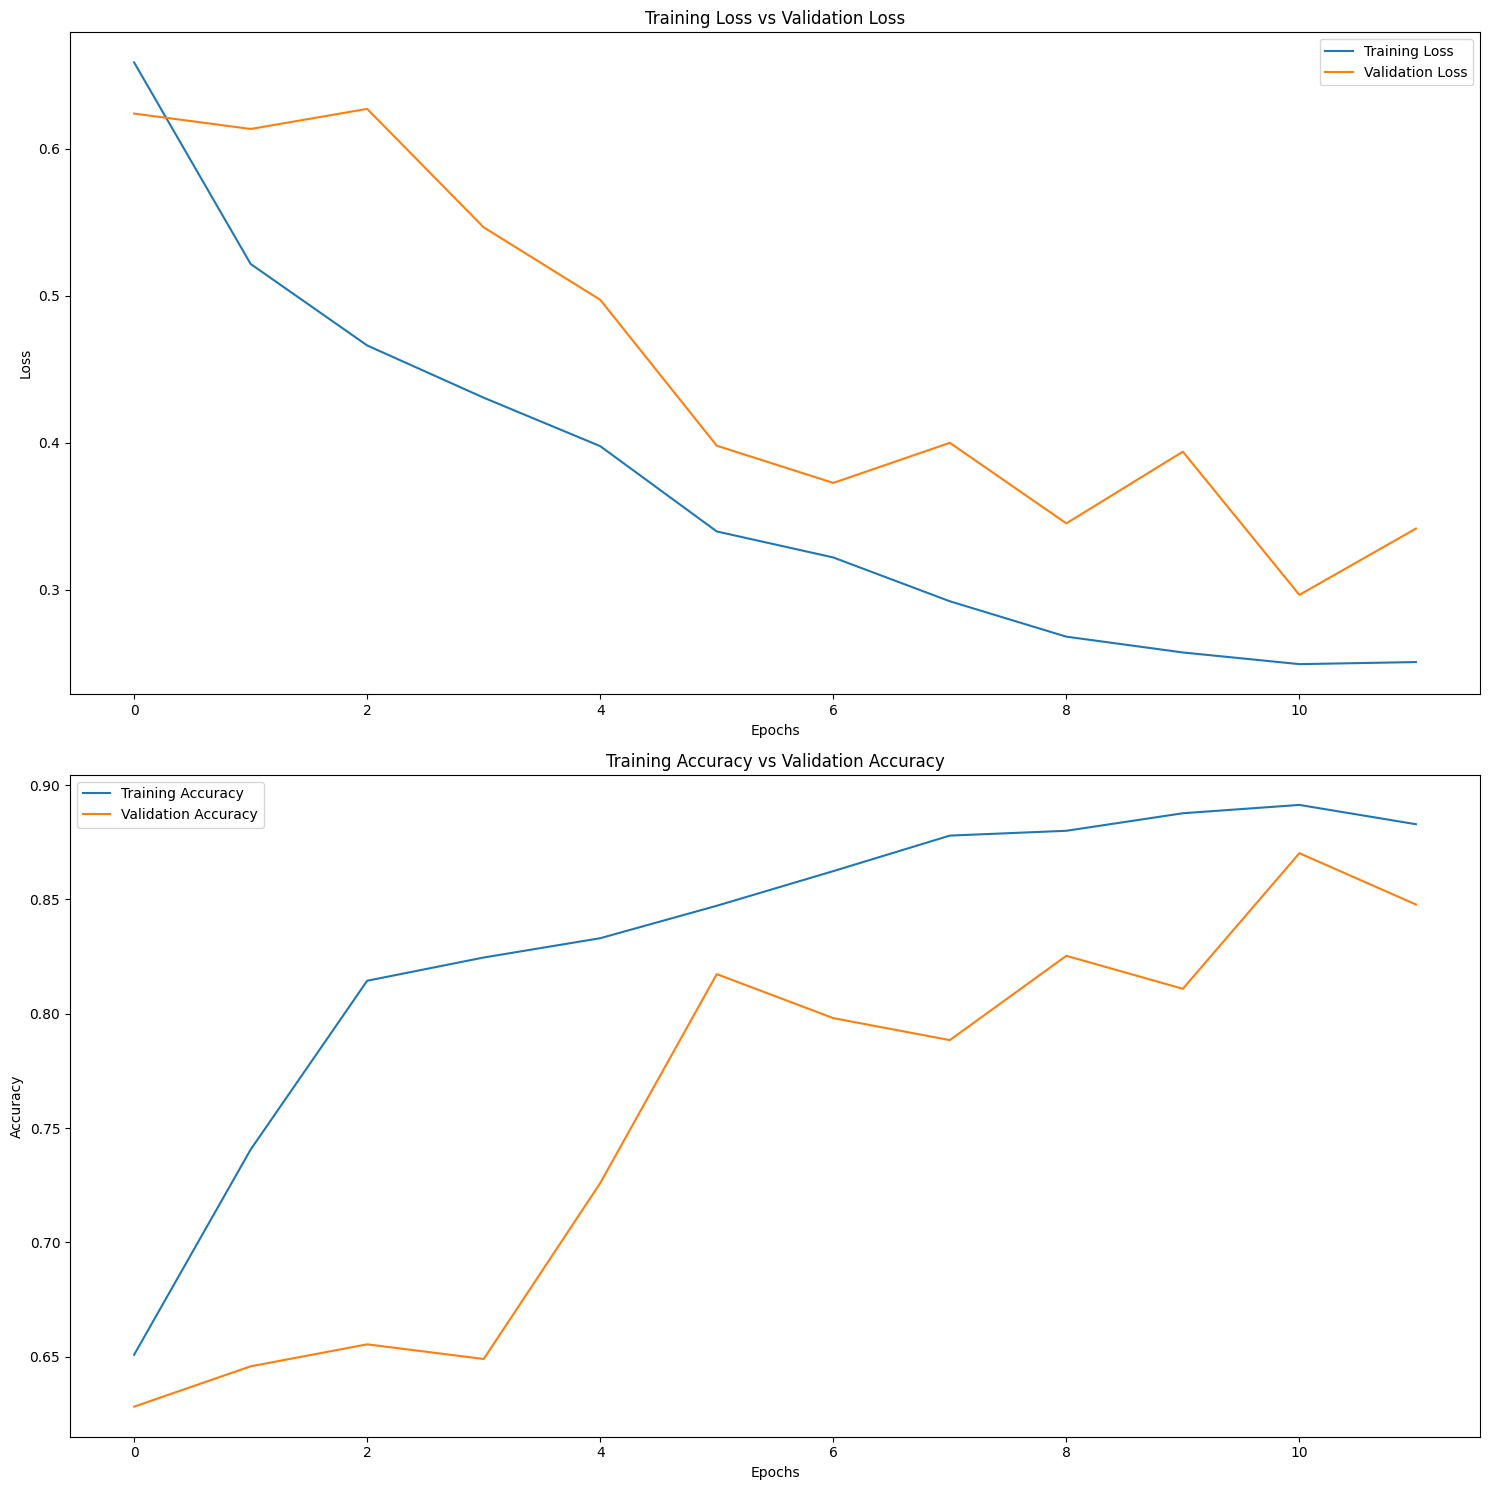

In [18]:

fig, axs = plt.subplots(2, 1, figsize=(15, 15))

# Plot Loss
axs[0].plot(history.history['loss'], label='Training Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history['accuracy'], label='Training Accuracy')
axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

#Confusion matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


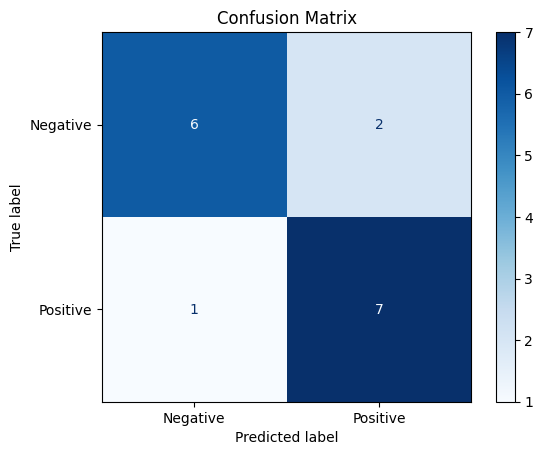

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict using the model
y_pred = model_1.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int")  # For binary classification

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Define class names
class_names = ['Negative', 'Positive']  # Example class names

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


True Negative (TN) = 6 <br>
True Positive (TP) = 7<br>
False Positive (FP) = 2<br>
False Negative (FN) = 1<br><br>

The model has overall accuracy (81.25%).


#8. Transfer learning

Transfer learning aims to leverage the learned knowledge from a resource-rich domain/task to help learning a task with not sufficient training data.

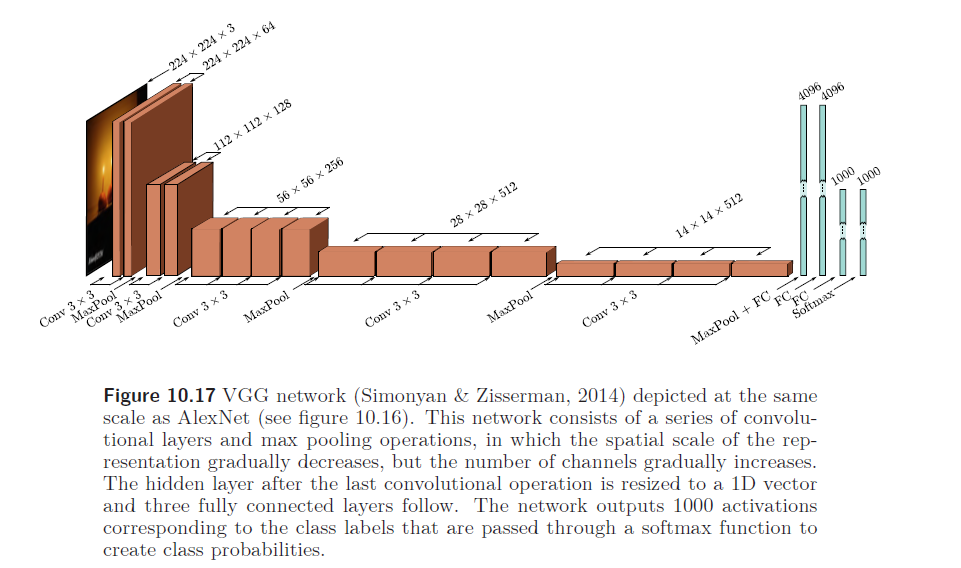

In [19]:
from tensorflow.keras.applications import VGG16

transfer_model = VGG16(include_top = False, weights = "imagenet", input_shape = (256, 256, 3), pooling = "max",
                    classes = 2)

#transfer_model.load_weights("../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5")
transfer_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 512)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

model2 = Sequential()
model2.add(transfer_model)
model2.add(Flatten())

model2.add(Dense(128, activation = "relu"))
model2.add(Dense(64, activation = "relu"))
model2.add(Dense(32, activation = "relu"))
model2.add(Dense(1, activation = "sigmoid"))

# freeze the layers
for layer in transfer_model.layers:
    layer.trainable = False

model2.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [21]:
from keras.callbacks import EarlyStopping

history = model2.fit(datagen.flow(X_train, y_train, batch_size = 8), epochs = 12, validation_data = (X_val, y_val), steps_per_epoch = 100,
                               callbacks = [EarlyStopping(monitor = "val_loss", patience = 3, verbose = 1, restore_best_weights = True)])

Epoch 1/12
100/100 ━━━━━━━━━━━━━━━━━━━━ 53s 428ms/step - accuracy: 0.7416 - loss: 0.5255 - val_accuracy: 0.8237 - val_loss: 0.3972
Epoch 2/12
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.8577 - loss: 0.3373 - val_accuracy: 0.8333 - val_loss: 0.3908
Epoch 3/12
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 0.8676 - loss: 0.2950 - val_accuracy: 0.8429 - val_loss: 0.3532
Epoch 4/12
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 156ms/step - accuracy: 0.8718 - loss: 0.2930 - val_accuracy: 0.8558 - val_loss: 0.3401
Epoch 5/12
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.8936 - loss: 0.2319 - val_accuracy: 0.8381 - val_loss: 0.4300
Epoch 6/12
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.8858 - loss: 0.2635 - val_accuracy: 0.8157 - val_loss: 0.4061
Epoch 7/12
 52/100 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9095 - loss: 0.2291

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9091 - loss: 0.2335 - val_accuracy: 0.8734 - val_loss: 0.3217
Epoch 8/12
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.9141 - loss: 0.2157 - val_accuracy: 0.8718 - val_loss: 0.3282
Epoch 9/12
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.9101 - loss: 0.2180 - val_accuracy: 0.7244 - val_loss: 0.5121
Epoch 10/12
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 159ms/step - accuracy: 0.8749 - loss: 0.2725 - val_accuracy: 0.8702 - val_loss: 0.4616
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 7.


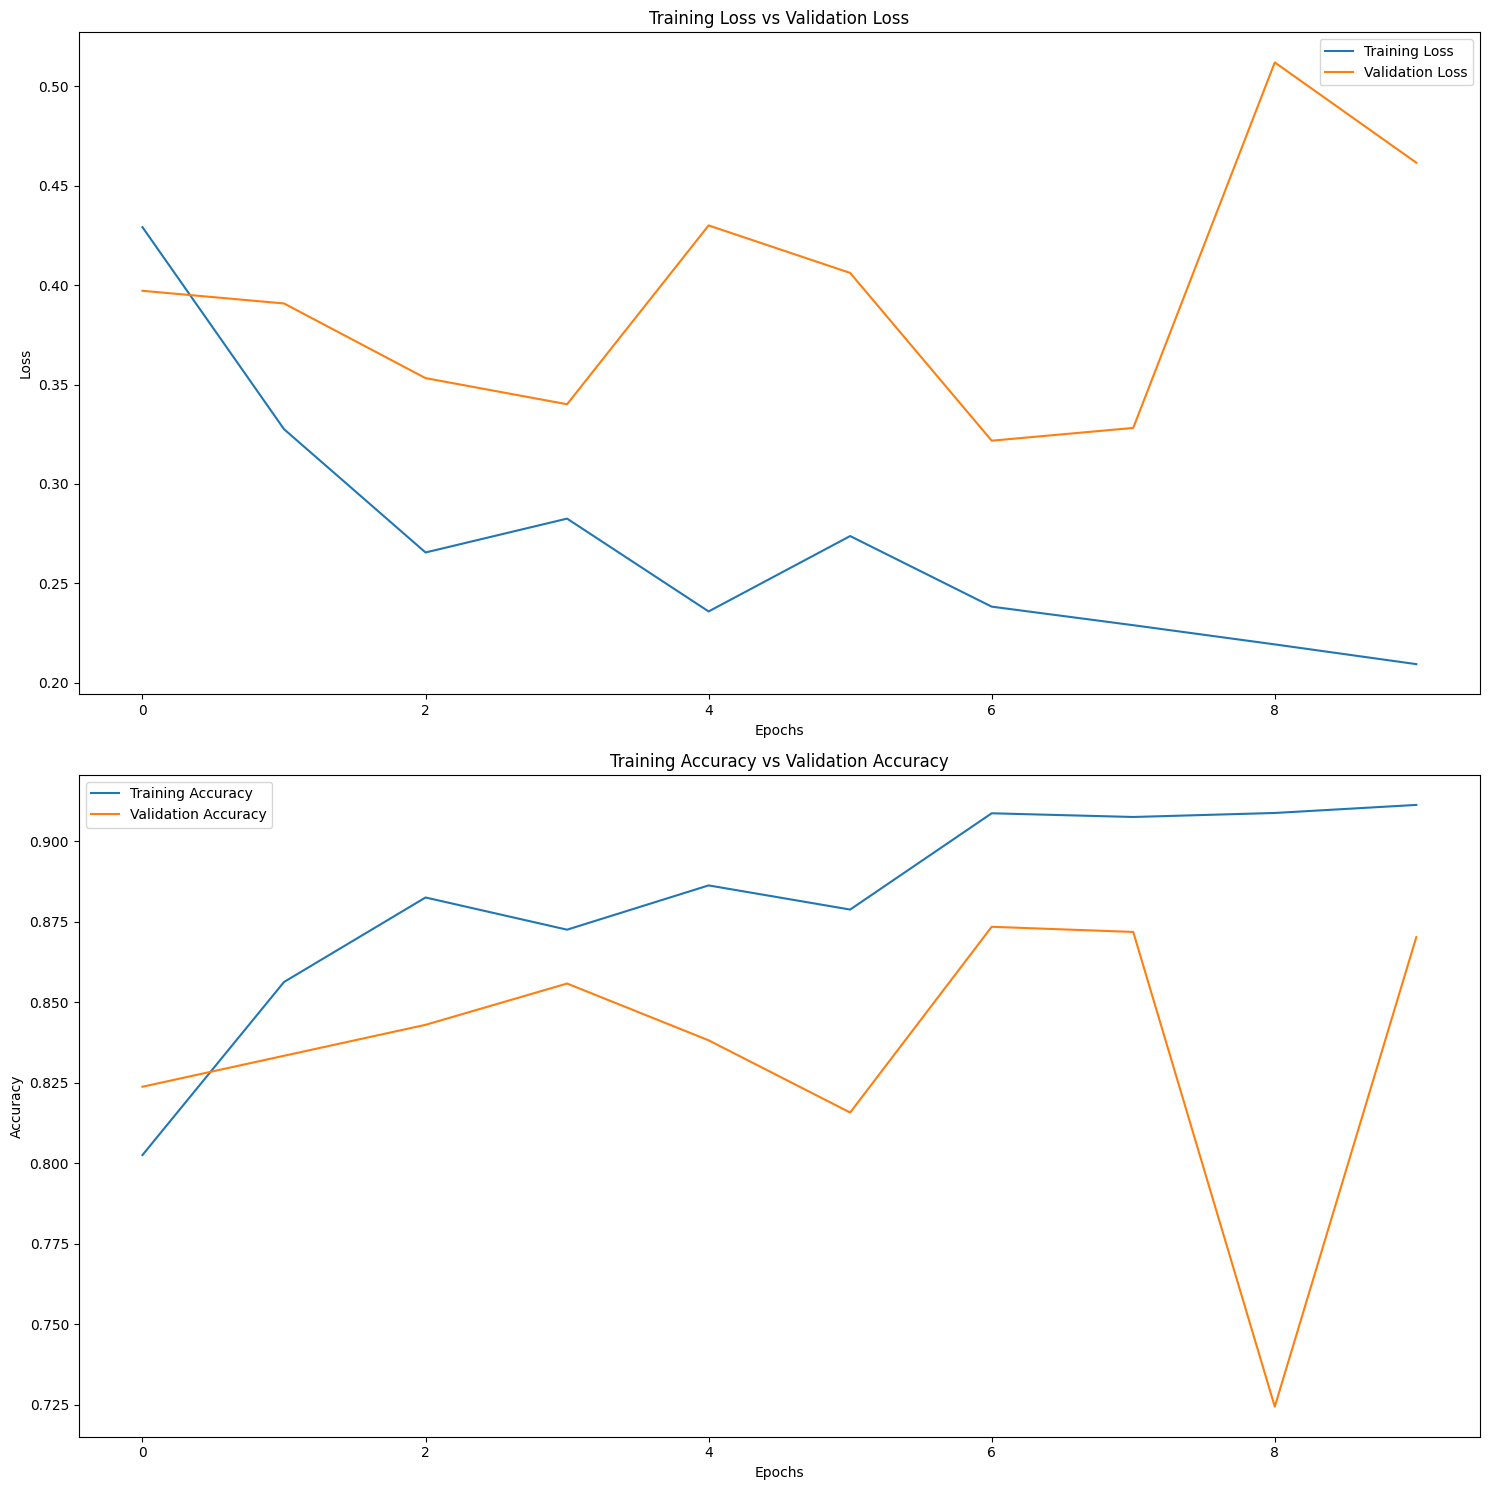

In [22]:

fig, axs = plt.subplots(2, 1, figsize=(15, 15))

# Plot Loss
axs[0].plot(history.history['loss'], label='Training Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history['accuracy'], label='Training Accuracy')
axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

In [23]:
print("Loss of the model is - " , model2.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model2.evaluate(X_test,y_test)[1]*100 , "%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8750 - loss: 0.4161
Loss of the model is -  0.4161493480205536
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8750 - loss: 0.4161
Accuracy of the model is -  87.5 %
